## Import Libraries

In [1]:
!pip install scikit-plot

In [2]:
import os
import warnings

import scipy as sp
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import numpy as np
import pandas as pd
import dateutil.relativedelta

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
from sklearn import metrics

import xgboost as xgb

from google.colab import drive

In [3]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

In [4]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
RANDOM_STATE = 42
DATA_PATH = "gdrive/MyDrive/EASY_MONEY_NUCLIO/data/"
FINAL_TARGETS = [
                 "em_acount",
                 "debit_card",
                 "cuentas",
                 "ahorro_inversion",
                 "financiacion"
]

PRODUCTS = [
    "short_term_deposit",	
    "loans",
    "mortgage",	
    "funds",
    "securities",
    "long_term_deposit",	
    "em_account_pp",	
    "credit_card",	
    "payroll",	
    "pension_plan",	
    "payroll_account",	
    "emc_account",	
    "debit_card",	
    "em_account_p",	
    "em_acount"	
]

PRICE = {
    "Finaciación": 60,
    "Ahorro/Inversion": 40,
    "Cuentas": 10
}

PRODUCTS_PRICED = {
    "short_term_deposit": "Ahorro/Inversion",	
    "loans": "Finaciación",
    "mortgage": "Finaciación",	
    "funds": "Ahorro/Inversion",
    "securities": "Ahorro/Inversion",
    "long_term_deposit": "Ahorro/Inversion",	
    "em_account_pp": "Cuentas",	
    "credit_card": "Finaciación",
    "pension_plan": "Ahorro/Inversion",	
    "payroll_account": "Cuentas",	
    "emc_account": "Cuentas",	
    "debit_card": "Finaciación",	
    "em_account_p": "Cuentas",	
    "em_acount": "Cuentas"	
}

## Load Data

In [6]:
df = pd.read_csv(DATA_PATH + "total_df.csv", sep=";", index_col=0)

In [7]:
# corregir fechas
df.loc[df["entry_date"] == "2015-02-29", "entry_date"] = "2015-02-28"
df.loc[df["entry_date"] == "2019-02-29", "entry_date"] = "2019-02-28"

In [8]:
DATES = df["pk_partition"].unique().tolist()

In [9]:
df["pk_partition"] = pd.to_datetime(df["pk_partition"], format="%Y-%m-%d")
df["entry_date"] = pd.to_datetime(df["entry_date"], format="%Y-%m-%d")

In [10]:
df.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2018-01-12,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,NaN


# EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   short_term_deposit  int64         
 3   loans               int64         
 4   mortgage            int64         
 5   funds               int64         
 6   securities          int64         
 7   long_term_deposit   int64         
 8   em_account_pp       int64         
 9   credit_card         int64         
 10  payroll             float64       
 11  pension_plan        float64       
 12  payroll_account     int64         
 13  emc_account         int64         
 14  debit_card          int64         
 15  em_account_p        int64         
 16  em_acount           int64         
 17  entry_date          datetime64[ns]
 18  entry_channel       object        
 19  active_customer     float64       
 20  se

In [12]:
df.isna().sum()

pk_cid                      0
pk_partition                0
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
em_account_pp               0
credit_card                 0
payroll                    61
pension_plan               61
payroll_account             0
emc_account                 0
debit_card                  0
em_account_p                0
em_acount                   0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
country_id                  0
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1512103
dtype: int64

In [13]:
df[["pk_cid", "pk_partition"]].duplicated().astype(int).sum()

0

## NaN's

In [14]:
df["salary"] = df["salary"].fillna(-9999)

In [15]:
df["region_code"] = df["region_code"].fillna(-99)

In [16]:
df["entry_channel"] = df["entry_channel"].fillna("Unknown")

In [17]:
df["pension_plan"].value_counts(dropna=False)

0.0    5745061
1.0     217802
NaN         61
Name: pension_plan, dtype: int64

In [18]:
df["pension_plan"] = df["pension_plan"].fillna(0.0)

In [19]:
df["gender"].value_counts(dropna=False)

H      3087502
V      2875397
NaN         25
Name: gender, dtype: int64

In [20]:
df["gender"] = df["gender"].fillna(df["gender"].mode().values[0])

In [21]:
df.isna().sum()

pk_cid                     0
pk_partition               0
short_term_deposit         0
loans                      0
mortgage                   0
funds                      0
securities                 0
long_term_deposit          0
em_account_pp              0
credit_card                0
payroll                   61
pension_plan               0
payroll_account            0
emc_account                0
debit_card                 0
em_account_p               0
em_acount                  0
entry_date                 0
entry_channel              0
active_customer            0
segment               133944
country_id                 0
region_code                0
gender                     0
age                        0
deceased                   0
salary                     0
dtype: int64

## Population Analysis

Antes de empezar con todo el pre-procesamiento, se realiza un análisis de los distintos productos disponibles para ver si sería factible tener un modelo para cada uno de ellos:

In [22]:
for product in PRODUCTS:
  if product not in ["payroll", "em_account_pp"]:
    print(f"#########{product}########")
    print(df.loc[df[product] == 1, [product, "age", "salary"]].describe())
    print("Predominant gender: ", df.loc[df[product] == 1, "gender"].mode().values[0])
    print("#####################")
    print("")

#########short_term_deposit########
       short_term_deposit           age        salary
count             15394.0  15394.000000  1.539400e+04
mean                  1.0     46.836690  9.187965e+04
std                   0.0     13.849793  1.914814e+05
min                   1.0     20.000000 -9.999000e+03
25%                   1.0     37.000000 -9.999000e+03
50%                   1.0     44.000000  8.017053e+04
75%                   1.0     55.000000  1.269798e+05
max                   1.0     97.000000  9.833873e+06
Predominant gender:  V
#####################

#########loans########
       loans         age         salary
count  468.0  468.000000     468.000000
mean     1.0   33.478632   95258.656923
std      0.0    9.633630   61072.220811
min      1.0   21.000000   -9999.000000
25%      1.0   26.000000   60530.880000
50%      1.0   30.000000   78374.385000
75%      1.0   37.250000  145972.320000
max      1.0   60.000000  228200.220000
Predominant gender:  V
#####################

###

Podemos observar como algunos productos se podrían agrupar debido a que el perfil de edad de los clientes es parecido. La variable "salary" no es un buen indicativo del cliente (se extrayeron los datos a partir de encuestas) para hacer esta agrupación.

A continuación, procederemos a comprobar la distribución de la clase positiva vs. la clase negativa para cada uno de los productos.

In [23]:
for product in PRODUCTS:
  if product != "payroll":
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")

del _df

#######short_term_deposit#######
0    451049
1      5324
Name: short_term_deposit, dtype: int64
0    0.988334
1    0.011666
Name: short_term_deposit, dtype: float64
########################

#######loans#######
0    456329
1        44
Name: loans, dtype: int64
0    0.999904
1    0.000096
Name: loans, dtype: float64
########################

#######mortgage#######
0    456348
1        25
Name: mortgage, dtype: int64
0    0.999945
1    0.000055
Name: mortgage, dtype: float64
########################

#######funds#######
0    454707
1      1666
Name: funds, dtype: int64
0    0.996349
1    0.003651
Name: funds, dtype: float64
########################

#######securities#######
0    454284
1      2089
Name: securities, dtype: int64
0    0.995423
1    0.004577
Name: securities, dtype: float64
########################

#######long_term_deposit#######
0    447262
1      9111
Name: long_term_deposit, dtype: int64
0    0.980036
1    0.019964
Name: long_term_deposit, dtype: float64
###############

Podemos ver como la tenencia de los distintos productos no esta balanceada en la gran mayoría de los casos.

También se puede observar como el producto em_account_pp no tiene ninguna venta en todo el histórico disponible.

Un buen enfoque para atacar este problema sería agrupar los productos en distintas categorías en función de lo parecida que sea la población que contrata cada producto, como de balanceado este el target (cada producto) y por productos similares.

In [24]:
cuentas = ["emc_account", "em_account_p", "payroll_account"]
ahorro_inversion = ["short_term_deposit", "long_term_deposit", "pension_plan", "securities", "funds"]
financiacion = ["credit_card", "mortgage", "loans"]

In [25]:
df["cuentas"] = df[cuentas].max(axis=1)
df["ahorro_inversion"] = df[ahorro_inversion].max(axis=1)
df["financiacion"] = df[financiacion].max(axis=1)

for group in [cuentas, ahorro_inversion, financiacion]:
  df = df.drop(group, axis=1)

In [26]:
for product in ["cuentas", "ahorro_inversion", "financiacion", "em_acount", "debit_card"]:
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")
  
del _df

#######cuentas#######
0    403699
1     52674
Name: cuentas, dtype: int64
0    0.884581
1    0.115419
Name: cuentas, dtype: float64
########################

#######ahorro_inversion#######
0.0    413955
1.0     42418
Name: ahorro_inversion, dtype: int64
0.0    0.907054
1.0    0.092946
Name: ahorro_inversion, dtype: float64
########################

#######financiacion#######
0    447810
1      8563
Name: financiacion, dtype: int64
0    0.981237
1    0.018763
Name: financiacion, dtype: float64
########################

#######em_acount#######
1    332728
0    123645
Name: em_acount, dtype: int64
1    0.72907
0    0.27093
Name: em_acount, dtype: float64
########################

#######debit_card#######
0    392837
1     63536
Name: debit_card, dtype: int64
0    0.860781
1    0.139219
Name: debit_card, dtype: float64
########################



Podemos ver como todos los nuevos productos estan bien balanceados excepto los productos de "financiacion", donde se puede observar que la muestra es claramente inferior a las otras categorías. Para esta categoría de productos prepararemos el modelo y en caso de ser necesario realizaremos alguna técnica de remuestreo para dar validez a las métricas obtenidas.

# Preprocessing

In [27]:
df["deceased"].value_counts()

N    5961849
S       1075
Name: deceased, dtype: int64

No podemos recomendar productos a clientes que estan muertos, por tanto, filtramos estos clientes.

In [28]:
df = df[df["deceased"] != "S"]

In [29]:
df = df[(df["age"] >= 18) & (df["age"] <= 90)]

In [30]:
cols_to_drop = ["segment", "deceased", "payroll", "em_account_pp"]
df = df.drop(cols_to_drop, axis=1)

In [31]:
print(df.shape)
print(df.columns)

(5921197, 15)
Index(['pk_cid', 'pk_partition', 'debit_card', 'em_acount', 'entry_date',
       'entry_channel', 'active_customer', 'country_id', 'region_code',
       'gender', 'age', 'salary', 'cuentas', 'ahorro_inversion',
       'financiacion'],
      dtype='object')


In [32]:
df["country_id"] = LabelEncoder().fit_transform(df["country_id"])

In [33]:
df["year"] = df["pk_partition"].dt.year
df["month"] = df["pk_partition"].dt.month

# eliminaremos esta columna posteriormente

In [34]:
df["entry_year"] = df["entry_date"].dt.year
df["entry_month"] = df["entry_date"].dt.month
df["entry_day"] = df["entry_date"].dt.day
df["entry_week"] = df["entry_date"].dt.week
df["entry_weekday"] = df["entry_date"].dt.weekday
df["entry_quarter"] = df["entry_date"].dt.quarter
df["entry_weekend"] = (df["entry_weekday"] >= 5).astype(int)

df = df.drop("entry_date", axis=1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921197 entries, 0 to 5962923
Data columns (total 23 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pk_cid            int64         
 1   pk_partition      datetime64[ns]
 2   debit_card        int64         
 3   em_acount         int64         
 4   entry_channel     object        
 5   active_customer   float64       
 6   country_id        int64         
 7   region_code       float64       
 8   gender            object        
 9   age               int64         
 10  salary            float64       
 11  cuentas           int64         
 12  ahorro_inversion  float64       
 13  financiacion      int64         
 14  year              int64         
 15  month             int64         
 16  entry_year        int64         
 17  entry_month       int64         
 18  entry_day         int64         
 19  entry_week        int64         
 20  entry_weekday     int64         
 21  entry_qu

In [36]:
def set_others(df, col, n):
    """
    Converts to Categorical column and sets Others for the categories outside the top n
    :param df: DataFrame object
    :param col: column name
    :param n: top X
    :return 
    """
    top_categories = df[col].value_counts().head(n)
    top_categories_list = top_categories.index.tolist()
    top_categories_list.append("Others")

    df[col] = pd.Categorical(df[col], categories=top_categories_list)
    return df[col].fillna("Others")

In [37]:
df["entry_channel"].value_counts().head(8)

KHE        3113575
KFC         873049
KHQ         590224
KAT         405973
KHK         229826
KHM         176333
Unknown     132171
KHN         108157
Name: entry_channel, dtype: int64

In [38]:
df["entry_channel"] = set_others(df, "entry_channel", 8)

In [39]:
def one_hot_encoder(data, col):
    _dummy_dataset = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, _dummy_dataset], axis=1)
    del data[col]
    del _dummy_dataset

    return data

In [40]:
df = one_hot_encoder(df, "entry_channel")

In [41]:
# region_code frequency encoding
region_counter = df["region_code"].value_counts(dropna=False)
df["region_code"] = df["region_code"].replace(region_counter)

In [42]:
df["gender"] = (df["gender"] == "H").astype(int)

In [43]:
# guardamos el df para poder extraer la base de clientes sobre la que predecir a futuro
df.to_pickle("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/preprocessed_df.pkl")

# Dataset Resampling

Queremos predecir las compras de los productos para el mes de Junio del 2019. Para poder implementar esto correctamente tendremos que coger los datos para "train/test" desde Enero del 2018 hasta Abril del 2019 y nos guardaremos Mayo del 2019 para validación.

Una vez convertidos los datos para que el modelo los entienda, tendremos que preparar el conjunto de datos para que cada row represente a un cliente. 

Para realizar esto, se extraerá la fecha mínima de compra de cada cliente, le restaremos un mes a esa fecha y extraeremos la row correspondiente que contenga dicha fecha para cada cliente. Esto se realiza para conseguir la información de aquellos clientes a mes m1, ya que son los clientes que van a comprar el mes siguiente.

Con tal de que el modelo no aprenda a predecir mejor las compras en aquellos meses donde hay más predominancia de compras vs. no compras, realizaremos un rebalanceo mes a mes. El objetivo es conseguir un ratio de 90-10 de la clase negativa vs. la clase positiva.

In [44]:
TARGETS = [
         "em_acount",
         "debit_card",
         "cuentas",
         "ahorro_inversion",
         "financiacion"
]

In [45]:
def get_compras(df, target):
  compras = df[(df[target] == 1) & (df["pk_partition"] != "2018-01-28")].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  compras["mes_m1"] = compras["pk_partition"].dt.date - pd.DateOffset(months=1)
  del compras["pk_partition"]
  compras.columns = ["pk_partition"]
  compras["compra"] = 1

  return compras

def clean_compras(df_compras, df):
  df_compras["pk_cid"] = df_compras.index
  c_cid_partition_tupled = df_compras[["pk_cid", "pk_partition"]].apply(tuple, axis=1)
  df_cid_partition_tupled = df[["pk_cid", "pk_partition"]].apply(tuple, axis=1)

  df_compras = df_compras[c_cid_partition_tupled.isin(df_cid_partition_tupled.tolist())]
  del df_compras["pk_cid"]

  return df_compras

def clean_no_compras(df_compras, df_no_compras):
  intersection = set(df_compras.index).intersection(df_no_compras.index.tolist())
  df_no_compras = df_no_compras.drop(intersection, axis=0)

  return df_no_compras

def get_month_subset(df_compras, df_no_compras, month):
  compras = df_compras[df_compras["pk_partition"] == month]
  no_compras = df_no_compras[df_no_compras["pk_partition"] <= month] 
  # miramos que los clientes que estan en compras no esten en no compras
  no_compras_cleaned = no_compras[~ no_compras.index.isin(compras.index.tolist())]
  # cambiamos el mes de las no compras
  no_compras_cleaned["pk_partition"] = compras["pk_partition"].values[0]

  return compras, no_compras_cleaned

Recorreremos cada target individualmente entre las fechas 2018-01 y 2019-04. Hay que tener en cuenta que estamos recorriendo para mes m1.

In [48]:
datasets = {}
for target in TARGETS:
  compras = get_compras(df, target)
  compras = clean_compras(compras, df)
  pool_no_compras = df[(df["em_acount"] == 0)].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  pool_no_compras = clean_no_compras(compras, pool_no_compras)
  pool_no_compras["compra"] = 0
  dataset_target = pd.DataFrame(columns=["pk_partition", "compra"])
  for month in DATES[0:-1]:
    compras_month, no_compras_clean = get_month_subset(compras, pool_no_compras, month)
    sample_size_nc = int(9 * compras_month.shape[0])
    if sample_size_nc <= no_compras_clean.shape[0]:
      no_compras_sample = no_compras_clean.sample(sample_size_nc)
      pool_no_compras = pool_no_compras.drop(no_compras_sample.index, axis=0)
      dataset_month = pd.concat([compras_month, no_compras_sample], axis=0)
    else:
      compras_month_sample = compras_month.sample(no_compras_clean.shape[0] // 9)
      pool_no_compras = pool_no_compras.drop(no_compras_clean.index, axis=0)
      dataset_month = pd.concat([compras_month_sample, no_compras_clean], axis=0)
    
    dataset_target = pd.concat([dataset_month, dataset_target], axis=0)
  
  datasets[target] = dataset_target

In [49]:
# cruzamos los pk_cid y pk_partition con df para sacar los datos de los clientes en las particiones deseadas
for target, dataset in datasets.items():
  dataset = dataset.reset_index()
  dataset.columns = ["pk_cid", "pk_partition", "compra"]
  print(dataset.shape)
  datasets[target] = pd.merge(dataset, df, on=["pk_cid", "pk_partition"], how="left")
  # borramos los targets originales del dataset resampleado para mantener un único target
  datasets[target] = datasets[target].drop(TARGETS, axis=1)
  print(datasets[target].shape)
  print("")

(149285, 3)
(149285, 27)

(166518, 3)
(166518, 27)

(156235, 3)
(156235, 27)

(156075, 3)
(156075, 27)

(60201, 3)
(60201, 27)



In [50]:
# guardar los datasets en pkl para no tener que calcularlos cada vez
for target, dataset in datasets.items():
  file_name = f"{target}_df.pkl"
  dataset.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")

# Load Pickles

In [53]:
# cargamos los pickles
FILES = os.listdir("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/")
DATASETS = {}
for file_name in FILES:
  if ("pkl" in file_name) and ("preprocessed" not in file_name):
    target, _ = file_name.split("_df.pkl")
    DATASETS[target] = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")
    DATASETS[target].drop(["pk_partition", "pk_cid", "entry_channel_Unknown"], axis=1, inplace=True)

In [54]:
# miramos que el target este bien balanceado (en el total)
for target, dataset in DATASETS.items():
  print(target)
  print(dataset["compra"].value_counts(dropna=False, normalize=True))
  print("")

em_acount
0    0.900037
1    0.099963
Name: compra, dtype: float64

debit_card
0    0.900029
1    0.099971
Name: compra, dtype: float64

ahorro_inversion
0    0.900022
1    0.099978
Name: compra, dtype: float64

financiacion
0    0.900051
1    0.099949
Name: compra, dtype: float64

cuentas
0    0.900029
1    0.099971
Name: compra, dtype: float64



Podemos observar como los distintos targets han quedado bien balanceados después de las distintas técnicas aplicadas.

Antes de realizar las correspondientes particiones del dataset, tendremos que asegurarnos de que no introducimos variables altamente correlacionadas al modelo.



### Financiación Correlation

In [55]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.005,0.016,-0.032,0.227,0.027,-0.205,-0.394,-0.076,-0.163,-0.020,-0.165,0.003,-0.172,-0.014,-0.251,0.137,-0.173,0.137,0.036,0.018,0.056,0.136
country_id,-0.005,1.000,-0.004,0.002,0.001,-0.002,0.001,0.005,0.004,-0.000,-0.001,-0.000,-0.001,-0.002,-0.004,-0.002,-0.007,-0.001,0.006,-0.003,-0.001,-0.001,0.011
region_code,0.016,-0.004,1.000,0.053,0.023,0.184,0.002,0.008,-0.017,0.038,-0.010,0.036,0.003,0.037,0.004,-0.012,-0.044,0.007,0.023,-0.043,-0.021,-0.016,0.129
gender,-0.032,0.002,0.053,1.000,-0.049,0.011,0.018,0.032,0.009,0.047,0.006,0.048,-0.006,0.052,0.002,0.097,-0.091,0.047,0.008,-0.041,-0.016,-0.009,0.006
age,0.227,0.001,0.023,-0.049,1.000,0.015,-0.107,-0.190,-0.010,-0.251,-0.024,-0.253,0.011,-0.271,-0.010,-0.455,0.220,-0.235,0.214,0.101,0.044,0.073,0.133
salary,0.027,-0.002,0.184,0.011,0.015,1.000,-0.059,-0.019,-0.093,-0.005,-0.009,-0.005,-0.001,-0.006,-0.003,0.052,0.008,-0.078,0.020,-0.004,-0.053,-0.035,0.039
year,-0.205,0.001,0.002,0.018,-0.107,-0.059,1.000,-0.199,0.218,0.079,0.027,0.079,-0.017,0.084,-0.006,0.019,-0.135,0.277,-0.096,-0.053,0.208,0.109,-0.058
month,-0.394,0.005,0.008,0.032,-0.190,-0.019,-0.199,1.000,0.165,0.104,0.032,0.108,-0.012,0.111,0.003,0.162,-0.180,0.120,-0.139,0.014,0.067,0.066,-0.067
entry_year,-0.076,0.004,-0.017,0.009,-0.010,-0.093,0.218,0.165,1.000,-0.155,0.035,-0.162,-0.049,-0.153,-0.004,-0.244,-0.283,0.315,-0.113,0.279,0.259,0.210,0.052
entry_month,-0.163,-0.000,0.038,0.047,-0.251,-0.005,0.079,0.104,-0.155,1.000,0.008,0.988,-0.001,0.971,0.013,0.358,-0.198,0.123,-0.068,-0.105,-0.004,-0.039,-0.130


Observamos como las parejas de features ("entry_week", "entry_month"), ("entry_quarter", "entry_month") y ("entry_week", "entry_quarter") estan muy correlacionadas entre ellas. Eliminaremos aquella que menos información nos aporte.

In [56]:
DATASETS["financiacion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [57]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.005,0.016,-0.032,0.227,0.027,-0.205,-0.394,-0.076,-0.020,-0.165,0.003,-0.014,-0.251,0.137,-0.173,0.137,0.036,0.018,0.056,0.136
country_id,-0.005,1.000,-0.004,0.002,0.001,-0.002,0.001,0.005,0.004,-0.001,-0.000,-0.001,-0.004,-0.002,-0.007,-0.001,0.006,-0.003,-0.001,-0.001,0.011
region_code,0.016,-0.004,1.000,0.053,0.023,0.184,0.002,0.008,-0.017,-0.010,0.036,0.003,0.004,-0.012,-0.044,0.007,0.023,-0.043,-0.021,-0.016,0.129
gender,-0.032,0.002,0.053,1.000,-0.049,0.011,0.018,0.032,0.009,0.006,0.048,-0.006,0.002,0.097,-0.091,0.047,0.008,-0.041,-0.016,-0.009,0.006
age,0.227,0.001,0.023,-0.049,1.000,0.015,-0.107,-0.190,-0.010,-0.024,-0.253,0.011,-0.010,-0.455,0.220,-0.235,0.214,0.101,0.044,0.073,0.133
salary,0.027,-0.002,0.184,0.011,0.015,1.000,-0.059,-0.019,-0.093,-0.009,-0.005,-0.001,-0.003,0.052,0.008,-0.078,0.020,-0.004,-0.053,-0.035,0.039
year,-0.205,0.001,0.002,0.018,-0.107,-0.059,1.000,-0.199,0.218,0.027,0.079,-0.017,-0.006,0.019,-0.135,0.277,-0.096,-0.053,0.208,0.109,-0.058
month,-0.394,0.005,0.008,0.032,-0.190,-0.019,-0.199,1.000,0.165,0.032,0.108,-0.012,0.003,0.162,-0.180,0.120,-0.139,0.014,0.067,0.066,-0.067
entry_year,-0.076,0.004,-0.017,0.009,-0.010,-0.093,0.218,0.165,1.000,0.035,-0.162,-0.049,-0.004,-0.244,-0.283,0.315,-0.113,0.279,0.259,0.210,0.052
entry_day,-0.020,-0.001,-0.010,0.006,-0.024,-0.009,0.027,0.032,0.035,1.000,0.085,-0.008,0.007,-0.005,-0.031,0.079,-0.015,-0.033,0.028,0.026,-0.007


### Ahorro/Inversión Correlation

In [58]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,-0.045,-0.041,0.199,-0.002,0.044,-0.211,0.071,-0.123,0.017,-0.124,-0.005,-0.130,-0.013,-0.186,0.027,-0.083,0.088,0.043,0.164,0.160,0.120
country_id,-0.001,1.000,-0.006,-0.001,0.001,-0.002,-0.001,0.001,0.001,-0.004,-0.001,-0.004,0.000,-0.005,-0.003,-0.004,-0.006,-0.002,0.019,-0.001,0.000,-0.001,0.004
region_code,-0.045,-0.006,1.000,0.053,-0.049,0.122,-0.026,0.036,-0.010,0.096,-0.035,0.093,-0.008,0.102,0.001,0.061,-0.047,0.026,-0.004,-0.042,-0.050,-0.031,0.053
gender,-0.041,-0.001,0.053,1.000,-0.087,0.004,-0.008,0.037,0.003,0.082,0.002,0.082,-0.006,0.087,0.007,0.102,-0.100,0.069,-0.009,-0.051,-0.039,-0.021,-0.004
age,0.199,0.001,-0.049,-0.087,1.000,-0.005,0.013,-0.126,0.017,-0.305,-0.020,-0.308,0.009,-0.323,-0.025,-0.381,0.270,-0.303,0.210,0.125,0.135,0.143,0.090
salary,-0.002,-0.002,0.122,0.004,-0.005,1.000,-0.094,0.023,-0.164,0.010,-0.027,0.008,0.004,0.007,0.007,0.123,0.046,-0.091,0.034,0.014,-0.072,-0.039,0.034
year,0.044,-0.001,-0.026,-0.008,0.013,-0.094,1.000,-0.689,0.316,-0.102,0.009,-0.102,-0.010,-0.103,-0.017,-0.139,-0.136,0.185,-0.075,-0.042,0.213,0.119,-0.033
month,-0.211,0.001,0.036,0.037,-0.126,0.023,-0.689,1.000,-0.062,0.162,0.019,0.165,-0.002,0.168,0.012,0.105,-0.044,-0.004,-0.063,-0.011,-0.079,-0.042,-0.039
entry_year,0.071,0.001,-0.010,0.003,0.017,-0.164,0.316,-0.062,1.000,-0.187,0.069,-0.188,-0.053,-0.184,-0.025,-0.430,-0.353,0.326,-0.156,0.124,0.302,0.197,-0.041
entry_month,-0.123,-0.004,0.096,0.082,-0.305,0.010,-0.102,0.162,-0.187,1.000,-0.007,0.984,0.007,0.970,0.033,0.331,-0.224,0.180,-0.081,-0.124,-0.088,-0.068,-0.109


In [59]:
DATASETS["ahorro_inversion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [60]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,-0.045,-0.041,0.199,-0.002,0.044,-0.211,0.071,0.017,-0.124,-0.005,-0.013,-0.186,0.027,-0.083,0.088,0.043,0.164,0.160,0.120
country_id,-0.001,1.000,-0.006,-0.001,0.001,-0.002,-0.001,0.001,0.001,-0.001,-0.004,0.000,-0.003,-0.004,-0.006,-0.002,0.019,-0.001,0.000,-0.001,0.004
region_code,-0.045,-0.006,1.000,0.053,-0.049,0.122,-0.026,0.036,-0.010,-0.035,0.093,-0.008,0.001,0.061,-0.047,0.026,-0.004,-0.042,-0.050,-0.031,0.053
gender,-0.041,-0.001,0.053,1.000,-0.087,0.004,-0.008,0.037,0.003,0.002,0.082,-0.006,0.007,0.102,-0.100,0.069,-0.009,-0.051,-0.039,-0.021,-0.004
age,0.199,0.001,-0.049,-0.087,1.000,-0.005,0.013,-0.126,0.017,-0.020,-0.308,0.009,-0.025,-0.381,0.270,-0.303,0.210,0.125,0.135,0.143,0.090
salary,-0.002,-0.002,0.122,0.004,-0.005,1.000,-0.094,0.023,-0.164,-0.027,0.008,0.004,0.007,0.123,0.046,-0.091,0.034,0.014,-0.072,-0.039,0.034
year,0.044,-0.001,-0.026,-0.008,0.013,-0.094,1.000,-0.689,0.316,0.009,-0.102,-0.010,-0.017,-0.139,-0.136,0.185,-0.075,-0.042,0.213,0.119,-0.033
month,-0.211,0.001,0.036,0.037,-0.126,0.023,-0.689,1.000,-0.062,0.019,0.165,-0.002,0.012,0.105,-0.044,-0.004,-0.063,-0.011,-0.079,-0.042,-0.039
entry_year,0.071,0.001,-0.010,0.003,0.017,-0.164,0.316,-0.062,1.000,0.069,-0.188,-0.053,-0.025,-0.430,-0.353,0.326,-0.156,0.124,0.302,0.197,-0.041
entry_day,0.017,-0.001,-0.035,0.002,-0.020,-0.027,0.009,0.019,0.069,1.000,0.071,-0.010,0.002,-0.043,-0.045,0.075,-0.022,-0.038,0.040,0.024,-0.014


### Debit Card Correlation

In [61]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,-0.035,-0.027,0.186,0.027,0.032,-0.247,0.006,-0.104,-0.025,-0.106,-0.005,-0.110,-0.009,-0.130,0.031,0.034,0.096,0.076,0.192,0.173,0.130
country_id,-0.001,1.000,-0.007,-0.002,0.004,-0.002,-0.002,-0.001,-0.001,-0.004,0.000,-0.004,0.000,-0.005,-0.003,-0.004,-0.006,-0.002,0.018,-0.002,-0.001,-0.001,0.007
region_code,-0.035,-0.007,1.000,0.052,-0.035,0.121,-0.056,0.037,-0.017,0.092,-0.036,0.088,-0.007,0.096,0.001,0.051,-0.034,-0.055,0.001,-0.037,-0.030,-0.020,0.058
gender,-0.027,-0.002,0.052,1.000,-0.084,0.006,-0.047,0.058,-0.008,0.082,-0.000,0.082,-0.004,0.086,0.010,0.102,-0.093,0.031,-0.007,-0.049,-0.027,-0.013,-0.000
age,0.186,0.004,-0.035,-0.084,1.000,-0.006,0.147,-0.259,0.032,-0.311,-0.023,-0.313,0.009,-0.328,-0.025,-0.383,0.259,-0.187,0.212,0.127,0.106,0.122,0.099
salary,0.027,-0.002,0.121,0.006,-0.006,1.000,-0.108,-0.015,-0.170,0.014,-0.027,0.013,0.004,0.011,0.007,0.125,0.051,-0.016,0.035,0.022,-0.022,-0.011,0.042
year,0.032,-0.002,-0.056,-0.047,0.147,-0.108,1.000,-0.574,0.416,-0.387,0.004,-0.383,-0.010,-0.383,-0.036,-0.169,-0.134,0.003,-0.061,-0.057,0.111,0.065,-0.036
month,-0.247,-0.001,0.037,0.058,-0.259,-0.015,-0.574,1.000,-0.016,0.403,0.019,0.400,-0.009,0.403,0.018,0.075,-0.117,0.115,-0.122,-0.042,0.004,0.002,-0.080
entry_year,0.006,-0.001,-0.017,-0.008,0.032,-0.170,0.416,-0.016,1.000,-0.218,0.058,-0.219,-0.051,-0.215,-0.027,-0.449,-0.357,0.193,-0.161,0.107,0.191,0.139,-0.059
entry_month,-0.104,-0.004,0.092,0.082,-0.311,0.014,-0.387,0.403,-0.218,1.000,-0.012,0.986,0.007,0.970,0.036,0.329,-0.203,0.044,-0.074,-0.130,-0.052,-0.061,-0.110


In [62]:
DATASETS["debit_card"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [63]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,-0.035,-0.027,0.186,0.027,0.032,-0.247,0.006,-0.025,-0.106,-0.005,-0.009,-0.130,0.031,0.034,0.096,0.076,0.192,0.173,0.130
country_id,-0.001,1.000,-0.007,-0.002,0.004,-0.002,-0.002,-0.001,-0.001,0.000,-0.004,0.000,-0.003,-0.004,-0.006,-0.002,0.018,-0.002,-0.001,-0.001,0.007
region_code,-0.035,-0.007,1.000,0.052,-0.035,0.121,-0.056,0.037,-0.017,-0.036,0.088,-0.007,0.001,0.051,-0.034,-0.055,0.001,-0.037,-0.030,-0.020,0.058
gender,-0.027,-0.002,0.052,1.000,-0.084,0.006,-0.047,0.058,-0.008,-0.000,0.082,-0.004,0.010,0.102,-0.093,0.031,-0.007,-0.049,-0.027,-0.013,-0.000
age,0.186,0.004,-0.035,-0.084,1.000,-0.006,0.147,-0.259,0.032,-0.023,-0.313,0.009,-0.025,-0.383,0.259,-0.187,0.212,0.127,0.106,0.122,0.099
salary,0.027,-0.002,0.121,0.006,-0.006,1.000,-0.108,-0.015,-0.170,-0.027,0.013,0.004,0.007,0.125,0.051,-0.016,0.035,0.022,-0.022,-0.011,0.042
year,0.032,-0.002,-0.056,-0.047,0.147,-0.108,1.000,-0.574,0.416,0.004,-0.383,-0.010,-0.036,-0.169,-0.134,0.003,-0.061,-0.057,0.111,0.065,-0.036
month,-0.247,-0.001,0.037,0.058,-0.259,-0.015,-0.574,1.000,-0.016,0.019,0.400,-0.009,0.018,0.075,-0.117,0.115,-0.122,-0.042,0.004,0.002,-0.080
entry_year,0.006,-0.001,-0.017,-0.008,0.032,-0.170,0.416,-0.016,1.000,0.058,-0.219,-0.051,-0.027,-0.449,-0.357,0.193,-0.161,0.107,0.191,0.139,-0.059
entry_day,-0.025,0.000,-0.036,-0.000,-0.023,-0.027,0.004,0.019,0.058,1.000,0.067,-0.005,0.005,-0.036,-0.038,0.088,-0.022,-0.037,0.012,0.009,-0.014


### Cuentas Correlation

In [64]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.004,-0.044,-0.031,0.189,-0.001,0.040,-0.133,0.089,-0.075,0.015,-0.076,-0.008,-0.080,-0.013,-0.163,-0.020,-0.062,0.065,0.064,0.208,0.213,0.116
country_id,-0.004,1.000,-0.006,-0.002,0.003,-0.002,-0.001,0.000,0.001,-0.005,-0.000,-0.005,0.000,-0.006,-0.002,-0.003,-0.006,-0.002,0.023,-0.001,-0.002,-0.001,0.002
region_code,-0.044,-0.006,1.000,0.053,-0.050,0.112,-0.032,0.043,-0.014,0.103,-0.039,0.100,-0.008,0.109,0.001,0.064,-0.040,0.028,-0.005,-0.042,-0.039,-0.026,0.045
gender,-0.031,-0.002,0.053,1.000,-0.084,0.005,-0.022,0.032,-0.011,0.084,-0.000,0.084,-0.004,0.089,0.011,0.099,-0.089,0.068,-0.004,-0.053,-0.041,-0.020,-0.002
age,0.189,0.003,-0.050,-0.084,1.000,-0.011,0.076,-0.122,0.058,-0.315,-0.021,-0.318,0.007,-0.331,-0.029,-0.372,0.249,-0.304,0.197,0.140,0.150,0.161,0.091
salary,-0.001,-0.002,0.112,0.005,-0.011,1.000,-0.096,0.043,-0.162,0.017,-0.028,0.016,0.003,0.014,0.007,0.125,0.044,-0.078,0.033,0.020,-0.049,-0.026,0.033
year,0.040,-0.001,-0.032,-0.022,0.076,-0.096,1.000,-0.802,0.326,-0.182,0.011,-0.182,-0.004,-0.184,-0.021,-0.161,-0.116,0.107,-0.057,-0.060,0.134,0.074,-0.035
month,-0.133,0.000,0.043,0.032,-0.122,0.043,-0.802,1.000,-0.143,0.202,0.009,0.203,-0.003,0.206,0.015,0.091,0.023,0.015,-0.028,-0.015,-0.056,-0.033,-0.023
entry_year,0.089,0.001,-0.014,-0.011,0.058,-0.162,0.326,-0.143,1.000,-0.241,0.067,-0.242,-0.050,-0.239,-0.030,-0.478,-0.347,0.299,-0.154,0.106,0.244,0.166,-0.049
entry_month,-0.075,-0.005,0.103,0.084,-0.315,0.017,-0.182,0.202,-0.241,1.000,-0.013,0.985,0.008,0.970,0.038,0.332,-0.201,0.179,-0.071,-0.134,-0.029,-0.035,-0.098


In [65]:
DATASETS["cuentas"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [66]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.004,-0.044,-0.031,0.189,-0.001,0.040,-0.133,0.089,0.015,-0.076,-0.008,-0.013,-0.163,-0.020,-0.062,0.065,0.064,0.208,0.213,0.116
country_id,-0.004,1.000,-0.006,-0.002,0.003,-0.002,-0.001,0.000,0.001,-0.000,-0.005,0.000,-0.002,-0.003,-0.006,-0.002,0.023,-0.001,-0.002,-0.001,0.002
region_code,-0.044,-0.006,1.000,0.053,-0.050,0.112,-0.032,0.043,-0.014,-0.039,0.100,-0.008,0.001,0.064,-0.040,0.028,-0.005,-0.042,-0.039,-0.026,0.045
gender,-0.031,-0.002,0.053,1.000,-0.084,0.005,-0.022,0.032,-0.011,-0.000,0.084,-0.004,0.011,0.099,-0.089,0.068,-0.004,-0.053,-0.041,-0.020,-0.002
age,0.189,0.003,-0.050,-0.084,1.000,-0.011,0.076,-0.122,0.058,-0.021,-0.318,0.007,-0.029,-0.372,0.249,-0.304,0.197,0.140,0.150,0.161,0.091
salary,-0.001,-0.002,0.112,0.005,-0.011,1.000,-0.096,0.043,-0.162,-0.028,0.016,0.003,0.007,0.125,0.044,-0.078,0.033,0.020,-0.049,-0.026,0.033
year,0.040,-0.001,-0.032,-0.022,0.076,-0.096,1.000,-0.802,0.326,0.011,-0.182,-0.004,-0.021,-0.161,-0.116,0.107,-0.057,-0.060,0.134,0.074,-0.035
month,-0.133,0.000,0.043,0.032,-0.122,0.043,-0.802,1.000,-0.143,0.009,0.203,-0.003,0.015,0.091,0.023,0.015,-0.028,-0.015,-0.056,-0.033,-0.023
entry_year,0.089,0.001,-0.014,-0.011,0.058,-0.162,0.326,-0.143,1.000,0.067,-0.242,-0.050,-0.030,-0.478,-0.347,0.299,-0.154,0.106,0.244,0.166,-0.049
entry_day,0.015,-0.000,-0.039,-0.000,-0.021,-0.028,0.011,0.009,0.067,1.000,0.065,-0.007,0.003,-0.045,-0.042,0.076,-0.024,-0.039,0.032,0.022,-0.012


### EM Account Correlation

In [67]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,0.003,-0.032,0.262,0.023,0.067,-0.453,-0.035,-0.166,-0.062,-0.171,0.006,-0.179,-0.009,-0.203,0.117,0.016,0.146,0.089,0.195,0.174,0.171
country_id,-0.001,1.000,-0.007,-0.002,0.003,-0.002,-0.003,-0.002,-0.002,-0.004,-0.001,-0.004,0.002,-0.005,-0.002,-0.004,-0.005,-0.001,0.017,-0.001,-0.001,-0.001,0.008
region_code,0.003,-0.007,1.000,0.053,-0.051,0.123,-0.060,0.046,-0.033,0.103,-0.036,0.099,-0.008,0.109,-0.003,0.087,-0.047,-0.054,0.000,-0.042,-0.034,-0.028,0.056
gender,-0.032,-0.002,0.053,1.000,-0.088,0.007,-0.051,0.056,-0.006,0.086,0.003,0.086,-0.004,0.091,0.009,0.105,-0.092,0.013,-0.005,-0.050,-0.029,-0.014,0.001
age,0.262,0.003,-0.051,-0.088,1.000,-0.003,0.147,-0.262,0.001,-0.321,-0.030,-0.323,0.010,-0.337,-0.029,-0.377,0.266,-0.133,0.215,0.120,0.107,0.118,0.101
salary,0.023,-0.002,0.123,0.007,-0.003,1.000,-0.114,-0.036,-0.167,0.008,-0.019,0.007,0.004,0.005,0.005,0.126,0.050,-0.007,0.034,0.018,-0.030,-0.014,0.041
year,0.067,-0.003,-0.060,-0.051,0.147,-0.114,1.000,-0.468,0.457,-0.364,-0.022,-0.362,-0.010,-0.361,-0.033,-0.199,-0.154,0.104,-0.073,-0.045,0.192,0.117,-0.033
month,-0.453,-0.002,0.046,0.056,-0.262,-0.036,-0.468,1.000,0.101,0.389,0.025,0.386,-0.009,0.388,0.019,0.059,-0.188,0.051,-0.162,-0.025,-0.010,-0.004,-0.097
entry_year,-0.035,-0.002,-0.033,-0.006,0.001,-0.167,0.457,0.101,1.000,-0.184,0.044,-0.187,-0.052,-0.180,-0.023,-0.419,-0.381,0.147,-0.174,0.119,0.194,0.141,-0.061
entry_month,-0.166,-0.004,0.103,0.086,-0.321,0.008,-0.364,0.389,-0.184,1.000,0.000,0.986,0.007,0.970,0.035,0.340,-0.218,0.040,-0.086,-0.147,-0.060,-0.066,-0.122


In [68]:
DATASETS["em_acount"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [69]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
active_customer,1.000,-0.001,0.003,-0.032,0.262,0.023,0.067,-0.453,-0.035,-0.062,-0.171,0.006,-0.009,-0.203,0.117,0.016,0.146,0.089,0.195,0.174,0.171
country_id,-0.001,1.000,-0.007,-0.002,0.003,-0.002,-0.003,-0.002,-0.002,-0.001,-0.004,0.002,-0.002,-0.004,-0.005,-0.001,0.017,-0.001,-0.001,-0.001,0.008
region_code,0.003,-0.007,1.000,0.053,-0.051,0.123,-0.060,0.046,-0.033,-0.036,0.099,-0.008,-0.003,0.087,-0.047,-0.054,0.000,-0.042,-0.034,-0.028,0.056
gender,-0.032,-0.002,0.053,1.000,-0.088,0.007,-0.051,0.056,-0.006,0.003,0.086,-0.004,0.009,0.105,-0.092,0.013,-0.005,-0.050,-0.029,-0.014,0.001
age,0.262,0.003,-0.051,-0.088,1.000,-0.003,0.147,-0.262,0.001,-0.030,-0.323,0.010,-0.029,-0.377,0.266,-0.133,0.215,0.120,0.107,0.118,0.101
salary,0.023,-0.002,0.123,0.007,-0.003,1.000,-0.114,-0.036,-0.167,-0.019,0.007,0.004,0.005,0.126,0.050,-0.007,0.034,0.018,-0.030,-0.014,0.041
year,0.067,-0.003,-0.060,-0.051,0.147,-0.114,1.000,-0.468,0.457,-0.022,-0.362,-0.010,-0.033,-0.199,-0.154,0.104,-0.073,-0.045,0.192,0.117,-0.033
month,-0.453,-0.002,0.046,0.056,-0.262,-0.036,-0.468,1.000,0.101,0.025,0.386,-0.009,0.019,0.059,-0.188,0.051,-0.162,-0.025,-0.010,-0.004,-0.097
entry_year,-0.035,-0.002,-0.033,-0.006,0.001,-0.167,0.457,0.101,1.000,0.044,-0.187,-0.052,-0.023,-0.419,-0.381,0.147,-0.174,0.119,0.194,0.141,-0.061
entry_day,-0.062,-0.001,-0.036,0.003,-0.030,-0.019,-0.022,0.025,0.044,1.000,0.078,-0.005,0.011,-0.031,-0.036,-0.007,-0.017,-0.032,-0.010,-0.006,-0.017


# Train-Test-Validation Split

Como estamos siguiendo la lógica de predecir a mes m1 las ventas del mes siguiente, tendremos que separar el dataset en train, test y validación de la siguiente manera:


1.   Nos guardaremos los meses desde Febrero 2018 hasta Marzo 2019 para train-test (Enero 2018 a Abril 2019 a mes m1)

2.   Reservaremos Abril 2019 para validación (Mayo 2019 a mes m1)

3. Predeciremos las ventas de Mayo 2019 (Junio 2019 a mes m1)

In [70]:
for target, dataset in DATASETS.items():
  dataset["compra"] = dataset["compra"].astype(int)
  if target == "financiacion":
    # development = train + test
    dev_df = dataset[(dataset["year"] == 2018) | (dataset["month"] < 4)]
    # validation
    val_df = dataset[(dataset["year"] == 2019) & (dataset["month"] >= 4)]
  else:
    # development = train + test
    dev_df = dataset[(dataset["year"] == 2018) | (dataset["month"] < 4)]
    # validation
    val_df = dataset[(dataset["year"] == 2019) & (dataset["month"] >= 4)]

  # split X & y
  dev_df_X = dev_df.drop("compra", axis=1)
  val_df_X = val_df.drop("compra", axis=1)
  dev_df_y = dev_df[["compra"]]
  val_df_y = val_df[["compra"]]

  #val_df_X.drop(["year", "month"], axis=1, inplace=True)
  #dev_df_X.drop(["year", "month"], axis=1, inplace=True)
  
  # save pickles
  dev_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

In [71]:
def load_datasets(target):
  dev_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

  return dev_X, dev_y, val_X, val_y

In [72]:
# Random Holdout
for target in DATASETS.keys():
  dev_df_X, dev_df_y, val_df_X, val_df_y = load_datasets(target)
  X_train, X_test, y_train, y_test = train_test_split(
                                      dev_df_X,
                                      dev_df_y,
                                      test_size=0.25,
                                      random_state=RANDOM_STATE
                                     )
  # save pickles
  X_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_train.pkl")
  X_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_test.pkl")
  y_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_train.pkl")
  y_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_test.pkl")

# Modelling

In [73]:
class Model(object):
  def __init__(self, target, model):
    self.target = target
    self.model = model
    self.dir_path = f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{self.target}/"
  
  def load_train_test(self):
    self.X_train = pd.read_pickle(self.dir_path + "X_train.pkl")
    self.X_test = pd.read_pickle(self.dir_path + "X_test.pkl")
    self.y_train = pd.read_pickle(self.dir_path + "y_train.pkl")
    self.y_test = pd.read_pickle(self.dir_path + "y_test.pkl")
    self.X_val = pd.read_pickle(self.dir_path + "val_X.pkl")
    self.y_val = pd.read_pickle(self.dir_path + "val_y.pkl")

  def train(self):
    self.model.fit(self.X_train, self.y_train)
  
  def predict(self, x):
    return self.model.predict(x)
  
  def predict_proba(self, x):
    return self.model.predict_proba(x)[:, 1]
  
  @staticmethod
  def confusion_matrix(result_test, result_pred):
    print("Confusion matrix:")
    print("")
    return pd.crosstab(result_test, result_pred)
  
  def get_metrics(self, y, y_pred):
    print("Accuracy Score : " + str(accuracy_score(y, y_pred)))
    print("Precision Score : " + str(precision_score(y, y_pred)))
    print("Recall Score : " + str(recall_score(y, y_pred)))
    print("F1 Score : " + str(f1_score(y, y_pred)))

  def get_auc_metrics(self):
    print("AUC Train : " + str(roc_auc_score(self.y_train, self.predict_proba(self.X_train))))
    print("AUC Test : " + str(roc_auc_score(self.y_test, self.predict_proba(self.X_test))))
    print("AUC Val : " + str(roc_auc_score(self.y_val, self.predict_proba(self.X_val))))
    print("")
    fpr_train, tpr_train, _ = metrics.roc_curve(self.y_train, self.predict_proba(self.X_train))
    fpr_test, tpr_test, _ = metrics.roc_curve(self.y_test, self.predict_proba(self.X_test))
    fpr_val, tpr_val, _ = metrics.roc_curve(self.y_val, self.predict_proba(self.X_val))

    fig, ax = plt.subplots()
    plt.clf()
    plt.plot(fpr_train, tpr_train, label="Train")
    plt.plot(fpr_test, tpr_test, label="Test")
    plt.plot(fpr_val, tpr_val, label="Val")
    plt.plot([0, 1], [0, 1], color="blue", linestyle="--")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.show()
  
  def get_feature_importance(self):
    return pd.Series(em.model.feature_importances_, index=em.X_train.columns).sort_values(ascending=False).head(20)
  
  def save_model(self):
    with open(self.dir_path + "model.pkl", 'wb') as file:  
      pickle.dump(self.model, file)
  
  @staticmethod
  def load_model(path):
    with open(path + "model.pkl", "rb") as file:  
      model = pickle.load(file)
    return model

In [74]:
def model_summary(target, model):
  """
  Gives a general summary of the trained model.
  """
  m_targ = Model(target, model)

  m_targ.load_train_test()
  m_targ.train()

  y_test_pred = pd.DataFrame(m_targ.predict(m_targ.X_test), index=m_targ.y_test.index, columns=["PrediccionCompra"])
  y_test_score = pd.DataFrame(m_targ.predict_proba(m_targ.X_test), index=m_targ.y_test.index, columns=["CompraScore"])
  results_df = m_targ.y_test.join(y_test_pred, how= 'inner')
  results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
  results_df = results_df.join(y_test_score)

  m_targ.get_metrics(m_targ.y_test, y_test_pred)
  print("")
  print(m_targ.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"]))
  print("")
  m_targ.get_auc_metrics()
  print("")
  skplt.metrics.plot_cumulative_gain(m_targ.y_val, m_targ.model.predict_proba(m_targ.X_val))
  print("Saving model...")
  m_targ.save_model()
  print("Model saved in:")
  print(m_targ.dir_path)
  print("")

  return m_targ

## MODEL 1: em_acount 

Accuracy Score : 0.9381656641465703
Precision Score : 0.8176820888685296
Recall Score : 0.4920066152149945
F1 Score : 0.614352090862158

Confusion matrix:

PrediccionCompra      0     1
compra                       
0                 32216   398
1                  1843  1785

AUC Train : 0.9128472807301444
AUC Test : 0.9086398382834762
AUC Val : 0.7559114349784917



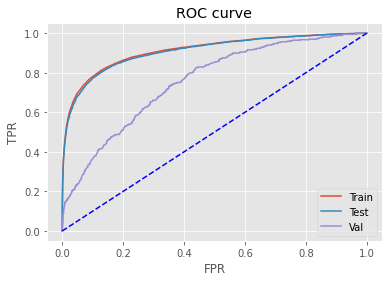


Saving model...
Model saved in:
/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/em_acount/



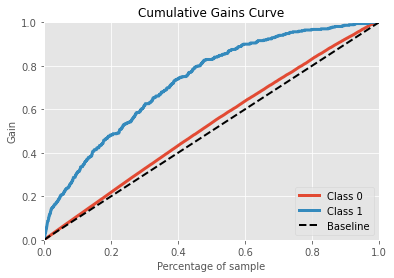

In [75]:
em = model_summary("em_acount", xgb.XGBClassifier(n_estimators=50, max_depth=6, min_samples_leaf=200))

En la curva ROC se puede comprobar que el modelo tiene un buen AUC en Train y en Test sin presencia de overfitting entre ellos. Sin embargo, salta a la vista el mal comportamiento del modelo en Validación. Esto podría ser debido a varios motivos que se expondrán a continuacion:

- Puede que el mes de validación no sea del todo bueno
- Puede que haya problemas temporales en los datos
- Puede que la distribución de algunas variables no sea del todo buena en validación

Analizando el gráfico de ganancia acumulada del modelo, se observa cómo se conseguirían de manera aproximada el 50% de las compras con tan solo el 20% de la muestra. El comportamiento del modelo se podría mejorar mucho aún para poder conseguir más % de compras con el mismo porcentaje de muestra.

A continuación se detallan las variables más importantes para el modelo.

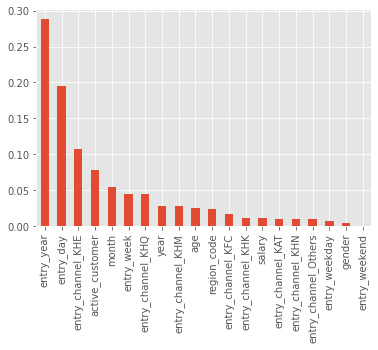

In [77]:
em.get_feature_importance().plot.bar()

## MODEL 2: debit_card

Accuracy Score : 0.9332020146611479
Precision Score : 0.6870019236053861
Recall Score : 0.6188118811881188
F1 Score : 0.6511264487563485

Confusion matrix:

PrediccionCompra      0     1
compra                       
0                 34927  1139
1                  1540  2500

AUC Train : 0.9364457456350496
AUC Test : 0.9394443245688735
AUC Val : 0.857362805217747



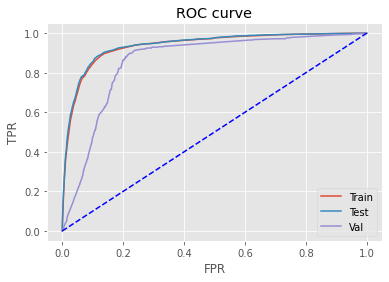


Saving model...
Model saved in:
/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/debit_card/



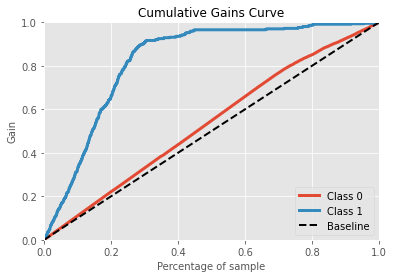

In [78]:
dc = model_summary("debit_card", xgb.XGBClassifier(n_estimators=50, min_samples_leaf=200))

En este modelo se observa un buen AUC en Train y en Test sin overfitting entre ellos. En Validación en AUC es alto, pero la curva que describe no se ajusta del todo bien a las otras dos. Sin embargo, este modelo consigue un 65% de las ventas con el 20% de la muestra.

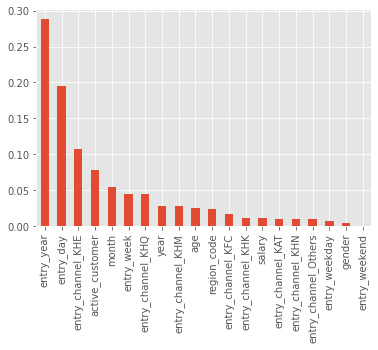

In [79]:
dc.get_feature_importance().plot.bar()

## MODEL 3: cuentas

Accuracy Score : 0.9256920438770788
Precision Score : 0.6755674232309746
Recall Score : 0.5351665785298784
F1 Score : 0.5972263204485099

Confusion matrix:

PrediccionCompra      0     1
compra                       
0                 31985   972
1                  1758  2024

AUC Train : 0.93296498939205
AUC Test : 0.933739666739124
AUC Val : 0.875176997824934



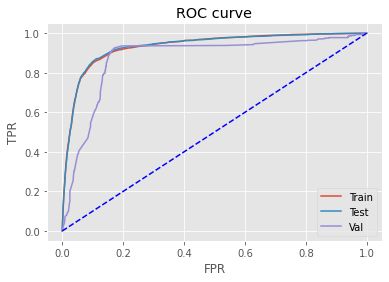


Saving model...
Model saved in:
/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/cuentas/



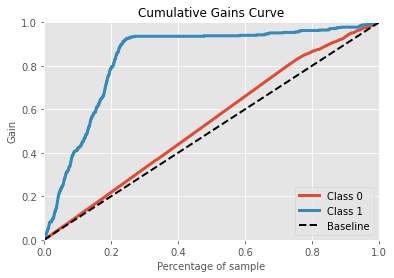

In [80]:
c = model_summary("cuentas", xgb.XGBClassifier(n_estimators=50, min_samples_leaf=200))

Este modelo, a diferencia del anterior, la curva ROC de validación se consigue ajustar mejor a la de Train y Test. Los tres AUC son buenos y el modelo es capaz de conseguir el 80% de las ventas con el 20% de la muestra.

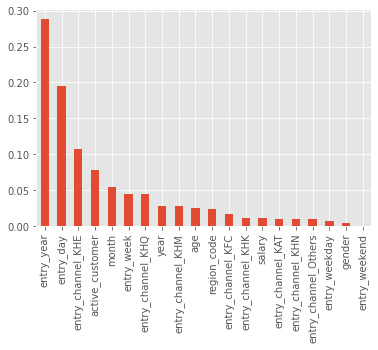

In [81]:
c.get_feature_importance().plot.bar()

## MODEL 4: ahorro_inversion

Accuracy Score : 0.9210586486795472
Precision Score : 0.6763727121464226
Recall Score : 0.450415512465374
F1 Score : 0.5407382773528434

Confusion matrix:

PrediccionCompra      0     1
compra                       
0                 30600   778
1                  1984  1626

AUC Train : 0.9090709909224945
AUC Test : 0.9083001322979967
AUC Val : 0.8319777719206376



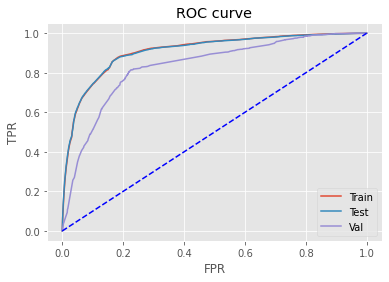


Saving model...
Model saved in:
/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/ahorro_inversion/



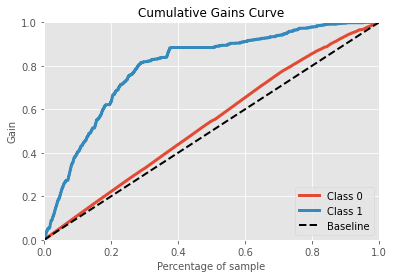

In [82]:
ah_i = model_summary("ahorro_inversion", xgb.XGBClassifier(n_estimators=50, min_samples_leaf=200))

Analizando el resumen generado, este modelo consigue buen AUC en Train, Test y Validación, pero con un poco de sobre-ajuste entre los dos primeros (Train-Test) y el tercero (Validación). El gráfico de ganancia nos muestra cómo el modelo es capaz de conseguir el 65% de las ventas con el 20% de la muestra de clientes.

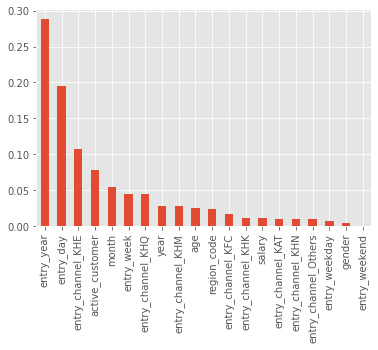

In [83]:
ah_i.get_feature_importance().plot.bar()

## MODEL 5: financiacion

Accuracy Score : 0.9176371544829521
Precision Score : 0.7857142857142857
Recall Score : 0.2333804809052334
F1 Score : 0.35986913849509267

Confusion matrix:

PrediccionCompra      0    1
compra                      
0                 12750   90
1                  1084  330

AUC Train : 0.8944092832252353
AUC Test : 0.8933550289274588
AUC Val : 0.9285893574297188



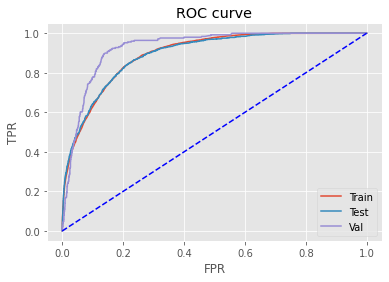


Saving model...
Model saved in:
/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/financiacion/



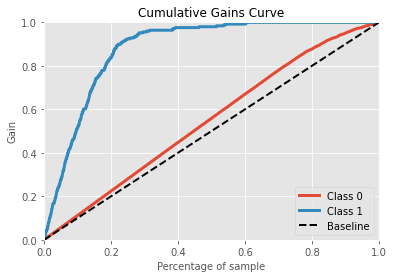

In [86]:
f = model_summary("financiacion", xgb.XGBClassifier(n_estimators=50, min_samples_leaf=100, max_depth=4))

Podemos ver claramente a partir del resumen anterior cómo el AUC de Validación es muy superior al de Train y Test, la cual cosa nos llega a pensar que puede haber algun problema con la distribución de las variables, algun problema temporal o que simplemente al ser el modelo con menos muestra de todos, los meses de validación escogidos no son del todo buenos.

In [87]:
f.X_val.describe()

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
count,2297.000000,2297.000000,2.297000e+03,2297.000000,2297.000000,2.297000e+03,2297.0,2297.0,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000
mean,0.304310,15.015237,5.340066e+05,0.471049,32.482368,6.488841e+04,2019.0,4.0,2017.227688,16.821071,31.764911,3.308228,0.374401,0.257292,0.154114,0.198084,0.049195,0.050065,0.139747,0.075751,0.045712
std,0.460215,0.518166,4.689397e+05,0.499270,12.976452,1.184789e+05,0.0,0.0,1.227217,8.978378,14.962890,2.166800,0.484073,0.437237,0.361137,0.398643,0.216321,0.218127,0.346800,0.264657,0.208905
min,0.000000,15.000000,2.242000e+03,0.000000,18.000000,-9.999000e+03,2019.0,4.0,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,1.164220e+05,0.000000,22.000000,-9.999000e+03,2019.0,4.0,2016.000000,9.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,15.000000,2.962640e+05,0.000000,28.000000,4.158054e+04,2019.0,4.0,2018.000000,17.000000,37.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,15.000000,1.162770e+06,1.000000,39.000000,1.027608e+05,2019.0,4.0,2018.000000,25.000000,43.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,34.000000,1.162770e+06,1.000000,88.000000,2.065610e+06,2019.0,4.0,2019.000000,31.000000,53.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
train_f = f.X_train
train_f[(train_f["year"] == 2018) & (train_f["month"] == 9)].describe()

,active_customer,country_id,region_code,gender,age,salary,year,month,entry_year,entry_day,entry_week,entry_weekday,entry_weekend,entry_channel_KHE,entry_channel_KFC,entry_channel_KHQ,entry_channel_KAT,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_Others
count,2270.000000,2270.0,2.270000e+03,2270.000000,2270.000000,2.270000e+03,2270.0,2270.0,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000
mean,0.185022,15.0,5.322132e+05,0.496476,31.916300,1.074515e+05,2018.0,9.0,2016.662555,16.840969,32.537885,3.448018,0.405727,0.371806,0.247137,0.060352,0.073128,0.055507,0.038767,0.025991,0.042291
std,0.388401,0.0,4.593757e+05,0.500098,13.269988,3.743223e+05,0.0,0.0,1.074057,9.209467,13.352730,2.188693,0.491140,0.483394,0.431442,0.238191,0.260403,0.229017,0.193081,0.159144,0.201296
min,0.000000,15.0,2.621000e+03,0.000000,19.000000,-9.999000e+03,2018.0,9.0,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.0,1.164220e+05,0.000000,22.000000,3.333140e+04,2018.0,9.0,2016.000000,9.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,15.0,3.558950e+05,0.000000,26.000000,7.513647e+04,2018.0,9.0,2017.000000,17.000000,35.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,15.0,1.162770e+06,1.000000,39.000000,1.251531e+05,2018.0,9.0,2018.000000,25.000000,43.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,15.0,1.162770e+06,1.000000,90.000000,1.138153e+07,2018.0,9.0,2018.000000,31.000000,53.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A analizar los estadísticos de un mes cualquiera del train con el mes de validación escogido se puede comprobar que no existen grandes cambios en las distribuciones de las variables de estos dos meses.

Se ha probado ampliar los meses de validación o incluso coger solo un mes anterior al mes propuesto y la situación sigue siendo la misma.

Una buena estrategia para este modelo, sería realizar un bootstrap debido a la poca cantidad de datos en el mes de validación y así conseguir un resultado promedio (no se realizará por falta de tiempo).

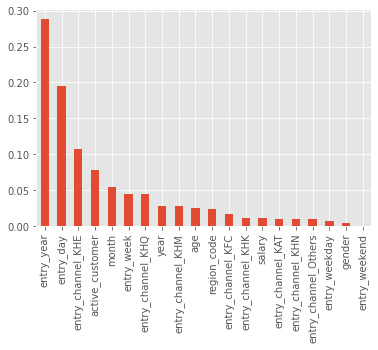

In [89]:
f.get_feature_importance().plot.bar()

# Get Scorings

In [90]:
X = pd.read_pickle("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/preprocessed_df.pkl")
X = X.drop(["entry_channel_Unknown", "entry_month", "entry_quarter", "pk_partition"], axis=1)
X = X[(X["year"] == 2019) & (X["month"] == 5)]
X = X.set_index("pk_cid")

A continuación, se predicen los scorings para cada uno de los modelos construidos. Para hacer esto, se ha decidido no tener en cuenta aquellos clientes que ya tienen contratado el target específico. Así conseguimos no impactar clientes con ese target ya contradado, puesto que tenemos un presupuesto para enviar 10.000 e-mails.

In [91]:
for target in FINAL_TARGETS:
  model = Model.load_model(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/")
  model = Model(target, model)
  target_X = X[X[target] != 1]
  target_X = target_X.drop(FINAL_TARGETS, axis=1)
  y = pd.DataFrame(model.predict_proba(target_X), index=target_X.index, columns=["Score"])
  y["target"] = target
  y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/scorings.pkl")

Al haber rebalanceado el dataset original mes a mes, los scorings obtenidos no representan una probabilidad de compra real. Para conseguir esto, tendríamos que aplicar técnicas de recalibrado. Un ejemplo de alguna de estas técnicas sería el Escalado de Platt, el cual consiste en entrenar a un modelo de regresión logística que se encarga de transformar los scorings a probabilidades calibradas

Sin embargo, al no haber indagado sobre estas técnicas en la duración del curso, no se aplicarán. Cabe destacar que aunque estas probabilidades no sean reales, el modelo ordena del mismo modo que si no se hubiera rebalanceado el dataset.

In [92]:
scorings = {}
for target in FINAL_TARGETS:
  scorings[target] = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/scorings.pkl")
  scorings[target] = scorings[target].sort_values(by="Score", ascending=False)

Para extraer esta muestra de 10.000 clientes más propensos a compra, se propuso en una primera instancia dar más peso a aquellos modelos que han conseguido una mejor curva de ganancia, lo que se traduce en que consiguen un mayor número de compras con la misma muestra de clientes. Sin embargo, al analizar los modelos y ver que algunos de ellos eran claramente mejorables, se ha optado por extraer el mismo % de clientes de cada lista de scorings.

Siguiendo la lógica anterior, para conseguir la lista de 10k clientes, se tendría que sacar una muestra ordenada de mayor a menor score de 2.000 clientes por cada target.

In [93]:
top_clients = pd.DataFrame(columns=["Score", "target"])
for scoring_df in scorings.values():
  top_clients = top_clients.append(scoring_df.head(2000))

top_clients = top_clients.reset_index().rename({"index": "user_id"}, axis=1).drop("Score", axis=1)
top_clients.to_csv("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/top_clients.csv")